# Investment and Trading Capstone Project
## Build a Stock Price Indicator
### Udacity - Machine Learning - Nanodegree  

Description

Investment firms, hedge funds and even individuals have been using financial models to better understand market behavior and make profitable investments and trades. A wealth of information is available in the form of historical stock prices and company performance data, suitable for machine learning algorithms to process.

For this project, your task is to build a stock price predictor that takes daily trading data over a certain date range as input, and outputs projected estimates for given query dates. Note that the inputs will contain multiple metrics, such as opening price (Open), highest price the stock traded at (High), how many stocks were traded (Volume) and closing price adjusted for stock splits and dividends (Adjusted Close); your system only needs to predict the Adjusted Close price.

You are free to choose what form your project takes (a simple script, a web app/service, Android/iOS app, etc.), and any additions/modifications you want to make to the project (e.g. suggesting what trades to make). Make sure you document your intended features in your report.

https://docs.google.com/document/d/1ycGeb1QYKATG6jvz74SAMqxrlek9Ed4RYrzWNhWS-0Q/pub

In [18]:
import math,string,sys,os

import datetime as DT
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date
from IPython.display import display, Image

from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import linear_model, decomposition, datasets, ensemble
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer,precision_score, recall_score, f1_score, average_precision_score, accuracy_score

from yahoo_finance import Share,Currency

%matplotlib inline

print "HelloWorld! We have imported what we want!"

HelloWorld! We have imported what we want!


## some function definitions 

In [38]:
def runPredict(clf,data, display=True):
    index=random.randrange(len(data))
    y_pred = clf.predict_proba(data[index].reshape(1, -1))[0]
    if display==True:
        print "for:",data[index], "\nprediction:",y_pred
    return y_pred

def train_classifier(clf, X_train, y_train):
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    return end - start
    #print "Done!\nTraining time (secs): {:.3f}".format(end - start)
    
# Predict on training set and compute F1 score
def predict_labels(clf, features, target):
    #print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    #print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return f1_score(target, y_pred,average='micro'),end - start #(None, 'micro', 'macro', 'weighted', 'samples')

# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):

    timeTrain=train_classifier(clf, X_train, y_train)
    predict_train,trainDelta=predict_labels(clf, X_train, y_train)
    predict_test,testDelta=predict_labels(clf, X_test, y_test)
    return predict_test,testDelta,predict_train,trainDelta,timeTrain # let's return the scores, so we can use them for comparisons

#for each data set size run and plot a train/test
def runTests(test_sizes, train_dataset,train_labels,test_dataset,test_labels, clf="", usePCA=False):
    test_f1=[]
    train_f1=[]

    for test_size in test_sizes:
        # Set up the train set for the test size
        X_train=train_dataset[:test_size]
        y_train=train_labels[:test_size]
        # Same for test
        X_test=test_dataset[-test_size:]
        y_test=test_labels[-test_size:]

 
        if clf == "":
            clf=LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42,  max_iter=200,C=.1, n_jobs = -1)
            
        if usePCA ==True:
            pca=decomposition.PCA(n_components = 14*14)
            clf=Pipeline(steps=[('pca', pca), ('classifier', clf )]) # set up the clf as a pipeline ])
        # Fit model to training data
        test,testDelta,train,trainDelta,timeTrain = train_predict(clf, X_train, y_train, X_test, y_test)
        test_f1.append(test)
        train_f1.append(train)
        print ("------------------------------------------")
        print ("Training set size: {},".format(len(X_train)),"Train time (secs): {:.3f}".format(timeTrain))
        print ("F1 score for training set: {},".format(train),"Prediction time (secs): {:.3f}".format(trainDelta))
        print ("F1 score for test set: {},".format(test),"Prediction time (secs): {:.3f}".format(testDelta))

    
    print ("\n",clf)
    print("Test F1:{}".format(test_f1))
    display("Train F1:{}".format(train_f1))
    plt.plot(test_f1,label="Test F1")
    plt.plot(train_f1,label="Train F1")
    plt.legend(loc=2)
    plt.title("F1 Score per run")
    plt.show()
    
    return clf    

In [39]:
# display the basic stock info
def display_stock_info(stock):
    print "date/time:", stock.get_trade_datetime()
    print "current_price:", stock.get_price()
    print "volume:",stock.get_volume()
    print "open:",stock.get_open()
    print "high:",stock.get_days_high()
    print "low:",stock.get_days_low()
    print "market cap:",stock.get_market_cap()
    print "P/E ratio:",stock.get_price_earnings_ratio()
    print "div yield:",stock.get_dividend_yield()

In [41]:
try:
    stock = Share('THR')
    print "Success?"
    print stock.get_info()
except Exception as e:
    print ("Data could not be loaded:")
    print(e)   
    
display_stock_info(stock)

Success?
{'symbol': 'THR'}
date/time: 2016-09-28 18:16:00 UTC+0000
current_price: 19.11
volume: 25622
open: 18.88
high: 19.13
low: 18.88
market cap: 616.43M
P/E ratio: 29.40
div yield: None


In [42]:
try:
    stock.refresh()
    print "Data refreshed"
except Exception as e:
    print ("Data could not be loaded:")
    print("error",e)  

display_stock_info(stock)

Data refreshed
date/time: 2016-09-28 20:02:00 UTC+0000
current_price: 19.26
volume: 74244
open: 18.88
high: 19.29
low: 18.88
market cap: 621.27M
P/E ratio: 29.63
div yield: None


In [ ]:
hist_begin='2011-09-28'
hist_end='2016-09-28'
try:
    stock_get_historical=stock.get_historical(hist_begin, hist_end)
    print "Historical data collected"
except Exception as e:
    print ("Data could not be loaded:")
    print("error",e)  

In [34]:
def get_historical_df(stock_get_historical):
    stock_hist=pd.DataFrame(stock_get_historical)
    # set the data types
    stock_hist['Date']=pd.to_datetime(stock_hist['Date'] )
    stock_hist['Adj_Close'] = stock_hist.Adj_Close.astype(np.float)
    stock_hist['Close'] = stock_hist.Close.astype(np.float)
    stock_hist['High'] = stock_hist.High.astype(np.float)
    stock_hist['Low'] = stock_hist.Low.astype(np.float)
    stock_hist['Open'] = stock_hist.Open.astype(np.float)
    stock_hist['Volume'] = stock_hist.Volume.astype(np.int64)
    
    #Demo how to change the date to be a num
    #stock_hist['Date'] = stock_hist.Date.astype(np.int64)
    #stock_hist['Date']=pd.to_datetime(stock_hist['Date'] )
    return stock_hist

stock_hist=get_historical_df(stock_get_historical)
print stock_hist.info()
display(stock_hist.head(4))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1258 entries, 0 to 1257
Data columns (total 8 columns):
Adj_Close    1258 non-null float64
Close        1258 non-null float64
Date         1258 non-null datetime64[ns]
High         1258 non-null float64
Low          1258 non-null float64
Open         1258 non-null float64
Symbol       1258 non-null object
Volume       1258 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 88.5+ KB
None


,Adj_Close,Close,Date,High,Low,Open,Symbol,Volume
0,18.830000,18.830000,2016-09-27,18.870001,18.530001,18.570000,THR,65300
1,18.660000,18.660000,2016-09-26,18.799999,18.580000,18.790001,THR,99600
2,18.780001,18.780001,2016-09-23,19.420000,18.770000,19.150000,THR,121800
3,19.219999,19.219999,2016-09-22,19.230000,18.910000,19.030001,THR,97000


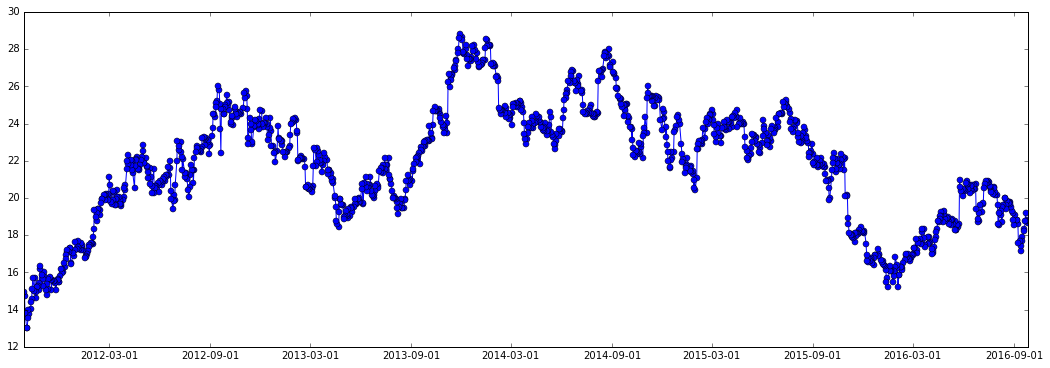

In [33]:
#x = [date2num(date) for (date, value) in Adj_Close_historical]
x = stock_hist['Date']
#y = [value for (date, value) in Adj_Close_historical]
y = stock_hist['Adj_Close']

fig = plt.figure(figsize=(18,6))
graph = fig.add_subplot(111)
# Plot the data as a red line with round markers
graph.plot(x,y,'b-o')
# Set the labels for the xticks used to cooresponding date 
ticklabels= [num2date(i).strftime("%Y-%m-%d") for i in graph.get_xticks().tolist()]
graph.set_xticklabels(ticklabels)

plt.show()
plt.close()

In [37]:
stock_hist.drop(['Symbol'],1,inplace=True)
print stock_hist.info()
display(stock_hist.head(4))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1258 entries, 0 to 1257
Data columns (total 7 columns):
Adj_Close    1258 non-null float64
Close        1258 non-null float64
Date         1258 non-null datetime64[ns]
High         1258 non-null float64
Low          1258 non-null float64
Open         1258 non-null float64
Volume       1258 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 78.6 KB
None


,Adj_Close,Close,Date,High,Low,Open,Volume
0,18.830000,18.830000,2016-09-27,18.870001,18.530001,18.570000,65300
1,18.660000,18.660000,2016-09-26,18.799999,18.580000,18.790001,99600
2,18.780001,18.780001,2016-09-23,19.420000,18.770000,19.150000,121800
3,19.219999,19.219999,2016-09-22,19.230000,18.910000,19.030001,97000


### EOF